In [1]:
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.interpolate import interp2d
import numpy as np
import xesmf as xe


import os, sys
sys.path.append("/home2/nhn2/py_packages")
from ingrid.times import to_pandas
from myplots.cplot import my_contourf

# comparing precip datasets - 
#   check grid names
#   check time grids
#   check units

var1 = 'tp'
var2 = 'precip'
file1 = '/net/kage/d5/datasets/ERAInterim/monthly/Accum/tp.nc'
file2 = '/net/kage/d5/datasets/GPCP/precip.mon.mean.nc'

In [2]:
files = [file1, file2]
ds = list(map(lambda x: xr.open_dataset(x,decode_times=False), files))

var = []
for dss in ds:
    varss = list(dss.data_vars)[0]
    var = var + [varss]
    print(list(dss.dims),dss[varss].shape,list(dss.data_vars))

['T', 'X', 'Y'] (456, 181, 360) ['tp']
['lat', 'lon', 'time'] (442, 72, 144) ['precip']


In [3]:
for dss in ds:
    print(list(dss.dims))
    if 'T' in list(dss.dims):
        dss = dss.rename({'T':'time'},inplace=True)  
    if 'X' in list(dss.dims):
        dss = dss.rename({'X':'lon','Y':'lat'},inplace=True)
    if 'latitude' in list(dss.dims):
        dss = dss.rename({'longitude':'lon','latitude':'lat'},inplace=True)
    print(list(dss.dims),'\n')
    #print(dss.time.attrs)
    if 'units' in list(dss.time.attrs):
        dss['time'] = to_pandas(dss.time)
    dss = dss.sortby('lat')    
    print(dss.lat.coords)

['T', 'X', 'Y']
['lat', 'lon', 'time'] 

Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 -85.0 -84.0 -83.0 ...
['lat', 'lon', 'time']
['lat', 'lon', 'time'] 

Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 -78.75 -76.25 -73.75 ...


In [25]:
# Check the units of the data and change if needed
for dss,varss in zip (ds,var):
    print('units of',varss,': ',dss[varss].units)
    

unit_pref = 'mm/day'
unit_convert = {'meter second-1':1000*3600*24,'m/s':1000*3600*24,'kg/m/s':3600*24}

for dss,varss in zip (ds,var):
    unit = dss[varss].units
    for units, fac in unit_convert.items():
        if unit in units:
            print('converting',unit,'to',unit_pref)
            dss[varss] = fac*dss[varss]
            dss[varss].attrs['units']=unit_pref
            
ds[0]

units of tp :  mm/day
units of precip :  mm/day


<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 456)
Coordinates:
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 85.0 84.0 83.0 82.0 81.0 ...
  * time     (time) datetime64[ns] 1979-01-16 1979-02-16 1979-03-16 ...
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
Data variables:
    tp       (time, lat, lon) float64 0.2722 0.2722 0.2722 0.2722 0.2722 ...
Attributes:
    history:  Wed May 23 17:30:54 2018: ncatted -a calendar,T,o,c,360_day tp.nc

In [26]:
ds1 = ds[0]; var1 = var[0]
ds2 = ds[1]; var1 = var[0]

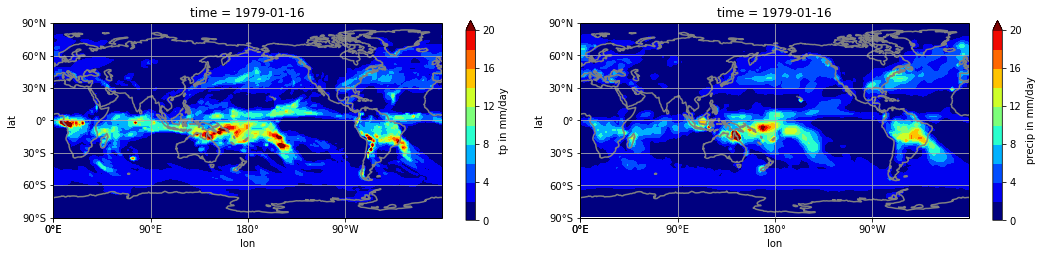

In [27]:
plt.figure(figsize=(15,4))
my_contourf(ds1[var1][0], subplot=121, vmin = 0, vmax=20, levels = 11, grid=True)
my_contourf(ds2[var2][0], subplot=122, vmin = 0, vmax=20, levels = 11, grid=True)
plt.tight_layout()

In [ ]:
# Method I  - regrid both to new grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-85, 85.01, 10.0)),
                     'lon': (['lon'], np.arange(5, 355.01, 10.0))})

ntimes = min(ds1.time.shape[0],ds2.time.shape[0])

regridder1 = xe.Regridder(ds1, ds_out, 'bilinear',periodic=True)
ds_out[var1] = (['time','lat','lon'],regridder1(ds1[var1][0:ntimes]))
ds_out[var1].attrs = {'units':'mm/day'}

regridder2 = xe.Regridder(ds2, ds_out, 'bilinear',periodic=True)
ds_out[var2] = (['time','lat','lon'],regridder2(ds2[var2][0:ntimes]))
ds_out[var2].attrs = {'units':'mm/day'}

In [ ]:
plt.figure(figsize=(15,4))
title = r'tp data on 10x10 grid'
my_contourf(ds_out[var1][0], subplot=121, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
title = r'precip on 10x10 grid'
my_contourf(ds_out[var2][0],subplot=122, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
plt.tight_layout()

In [ ]:
# Method II  - directly regrid ds1 to ds2
regridder = xe.Regridder(ds1, ds2, 'bilinear',periodic=True)

new = regridder(ds1[var1][0:ntimes])
ds2[var1] = (['time','lat','lon'],new)
ds2[var1].attrs = {'units':'mm/day'}

In [ ]:
plt.figure(figsize=(15,4))
title = r'tp data on ds1 grid'
my_contourf(ds1[var1][120], subplot=121, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
title = r'tp interpolated to ds2 grid'
my_contourf(ds2[var1][120],  subplot=122, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(18,10))
ds1[var1].mean(dim=['lon','lat']).plot()
ds2[var2].mean(dim=['lon','lat']).plot()
ds2[var1].mean(dim=['lon','lat']).plot()
plt.legend()

In [ ]:
plt.figure(figsize=(18,10))
ptitle = r'ERAInterim - GPCP climatolologies'
ds2['pr_diff'] = (ds2[var1]-ds2[var2]).mean('time')
ds2['pr_diff'].attrs = {'units':'mm/day'}
my_contourf(ds2.pr_diff, levels = 21,
            vmin=-3, vmax=3, cmap= 'BrBG', title=ptitle, grid=True)
plt.tight_layout()